In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q dgl

1.11.0+cu113


In [ ]:
import torch
import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.metrics import recall_score, precision_score

import seaborn as sns
import matplotlib.pyplot as plt

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Load data

In [ ]:
# open subgraphs pickle object
with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/address_subgraphs.pkl', "rb") as input_file:
    dataset = pickle.load(input_file)

# open node features
node_features = pd.read_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/node_address_features.csv', low_memory=False).fillna(0).set_index('address')
#entity = pd.read_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/entities_match_id.csv', low_memory=False)

In [ ]:
# clean NaN from node features
node_features = node_features.fillna(0)

In [ ]:
# check length on train and test
print(len(dataset[0])) 
print(len(dataset[1]))

18876
10207


In [ ]:
# set complete data together
dataset = dataset[0] + dataset[1]

In [ ]:
node_features.columns

Index(['timestep_app', 'deg_input_address', 'deg_output_address',
       'txns_input_address', 'txns_output_address', 'txn_total_input_address',
       'txn_total_output_address', 'fee_total_input_address',
       'fee_total_output_address', 'fee_share_input_address',
       'fee_share_output_address', 'txn_max_input_address',
       'txn_max_output_address', 'txn_min_input_address',
       'txn_min_output_address', 'txn_mean_input_address',
       'txn_mean_output_address', 'txn_median_input_address',
       'txn_median_output_address', 'repeat_partners', 'interaction_mean',
       'interaction_max', 'interaction_min', 'interaction_median'],
      dtype='object')

In [ ]:
# print metrics example for a subgraph
print('====================')
print(f'Number of graphs: {len(dataset)}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 29083

Data(edge_index=[2, 4], node='0002985a87', entity='nan', category='nan', num_nodes=5, x=[5, 24], y=node
0002985a87    0
Name: class, dtype: int64, edge_attr=[4, 4])
Number of nodes: 5
Number of edges: 4
Average node degree: 0.80
Has isolated nodes: False
Has self-loops: False
Is undirected: False


## Auxiliary functions

In [ ]:
# Auxiliary functions

# graphs the first n subgraphs from a list
def plot_graph_mosaic(lenx, leny, graph_list, graphx, graphy, title):
  fig, ax = plt.subplots(lenx,leny, figsize=(graphx,graphy))
  
  counter = 0
  for x in range(lenx):
    for y in range(leny):
      fig.suptitle(title)
      central_id = graph_list[counter].graph['central_id']
      category = graph_list[counter].graph['category']
      ax[x,y].set_title(label = f'num_nodes={str(len(graph_list[counter].nodes))}')
      color_map = []
      node_counter = 0
      max_degree = 0
      
      # get max degree
      degree_list = list(dict(nx.degree(graph_list[counter])).values())
      max_degree_value = max(degree_list)
      max_degree_node = degree_list.index(max_degree_value)
        
      # color central node and highest degree node
      for node in graph_list[counter]:
        if node_counter == 0:
          color_map.append('#F16209') # orangeish
        else:
          if max_degree_node == node_counter:
            color_map.append('yellow')
          else: 
            color_map.append('#1991B5') # blueish
        node_counter += 1

      g = nx.draw_networkx(graph_list[counter], node_size=50, node_color=color_map, with_labels=False, width=0.2, alpha=0.8, arrowsize=8, ax=ax[x,y])
      counter += 1
      plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# calculate average metrics for a given list of subgraphs
def calculate_metrics(graph_list, description):
  # intialize storage dictionaries
  g_metrics = {}
  g_avg_metrics = {}
  
  # calculate nx metrics. One per each subgraph in the list
  g_metrics['type'] = description
  g_metrics['num_nodes'] = [graph.number_of_nodes() for graph in graph_list]
  g_metrics['degree'] = [np.mean(list(dict(nx.degree(graph)).values())) for graph in graph_list]
  g_metrics['density'] = [nx.density(graph) for graph in graph_list]

  # extract data from node features table. One row per each subgraph in the list
  temp = pd.DataFrame([node_features.loc[graph.graph['central_id']]
          [['deg_input_address', 'deg_output_address', 
            'txns_input_address', 'txns_output_address',
            'txn_total_input_address','txn_total_output_address',
            'fee_total_input_address','fee_total_output_address',
            'fee_share_input_address','fee_share_output_address',
            'txn_mean_input_address', 'txn_mean_output_address']] for graph in graph_list])
  
  # assign node features metrics to data dictionary
  g_metrics['deg_input'] = temp['deg_input_address']
  g_metrics['deg_output'] = temp['deg_output_address']
  g_metrics['txns_input'] = temp['txns_input_address']
  g_metrics['txns_output'] = temp['txns_output_address']
  g_metrics['txn_total_input'] = temp['txn_total_input_address']
  g_metrics['txn_total_output'] = temp['txn_total_output_address']
  g_metrics['fee_total_input'] = temp['fee_total_input_address']
  g_metrics['fee_total_output'] = temp['fee_total_output_address']
  g_metrics['fee_share_input'] = temp['fee_share_input_address']
  g_metrics['fee_share_output'] = temp['fee_share_output_address']
  g_metrics['txn_mean_input'] = temp['txn_mean_input_address']
  g_metrics['txn_mean_output'] = temp['txn_mean_output_address']

  # average nx metrics for list of subgraphs
  g_avg_metrics['type'] = description
  g_avg_metrics['num_nodes'] = np.mean(g_metrics['num_nodes'])
  g_avg_metrics['degree'] = np.mean(g_metrics['degree'])
  g_avg_metrics['density'] = np.mean(g_metrics['density'])

  # average node feature metrics for list of subgraphs
  g_avg_metrics['deg_input'] = np.mean(g_metrics['deg_input'])
  g_avg_metrics['deg_output'] = np.mean(g_metrics['deg_output'])
  g_avg_metrics['txns_input'] = np.mean(g_metrics['txns_input'])
  g_avg_metrics['txns_output'] = np.mean(g_metrics['txns_output'])
  g_avg_metrics['txn_total_input'] = np.mean(g_metrics['txn_total_input'])
  g_avg_metrics['txn_total_output'] = np.mean(g_metrics['txn_total_output'])
  g_avg_metrics['fee_total_input'] = np.mean(g_metrics['fee_total_input'])
  g_avg_metrics['fee_total_output'] = np.mean(g_metrics['fee_total_output'])
  g_avg_metrics['fee_share_input'] = np.mean(g_metrics['fee_share_input'])
  g_avg_metrics['fee_share_output'] = np.mean(g_metrics['fee_share_output'])
  g_avg_metrics['txn_mean_input'] = np.mean(g_metrics['txn_mean_input'])
  g_avg_metrics['txn_mean_output'] = np.mean(g_metrics['txn_mean_output'])

  return g_avg_metrics

# get id of central node of a subgraph (not used)
def get_main_node_id(graph):
  if torch.is_tensor(graph.node):
    graph_id = str(graph.node.numpy()[0])
  else:
    graph_id = graph.node[0]
  return graph_id

# check if subgraph id is in the mismatched list (not used)
def check_mismatched(graph):
  graph_id = ''

  graph_id = get_main_node_id(graph)
  
  if graph_id in mismatched_graph:
    return True
  else:
    return False

# get address, entity name and category for a given node id (not used)
def get_entity(graph):
  entity_data = entity[entity.address_id==graph.graph['central_id']].values.flatten().tolist()
  return entity_data

# given a list of subgraphs draw a cat plot
def graph_entities(graph_list, drop_na, hue, title):
  data = pd.DataFrame([[graph.graph['central_id'], graph.graph['entity'], graph.graph['category']] for graph in graph_list], columns=['central_id','entity','category'])
  if drop_na:
    data = data[data.entity!='nan']
  else:
    data = data.replace('nan','unknown')

  if hue:
    g = sns.catplot(data=data, x='entity', col='category', col_wrap=3, kind='count');
  else:
    g = sns.catplot(data=data, x='category', kind='count');

  g.set_xticklabels(rotation=90)
  g.fig.suptitle(title);
  

##Licit vs illicit

In [ ]:
# count high risk and safe addresses (not used)
classes = {dataset[i].y.index.map(str)[0]: dataset[i].y.item() for i in range(len(dataset))}
classes_1 = dict(filter(lambda i: i[1] == 1, classes.items()))
classes_0 = dict(filter(lambda i: i[1] == 0, classes.items()))

print(f'Number of high risk addresses: {len(classes_1.keys())}')
print(f'Number of safe addresses: {len(classes_0.keys())}')

random.seed(1993)
classes_all_keys = list(classes.keys()) 

Number of high risk addresses: 10496
Number of safe addresses: 18587


In [ ]:
# separate licit and illicit subgraphs
illicit_subgraphs = [dataset[i] for i in range(len(dataset)) if dataset[i].y.item()==1]
licit_subgraphs = [dataset[i] for i in range(len(dataset)) if dataset[i].y.item()==0]
print(f'all:{len(dataset)} illicit:{len(illicit_subgraphs)} licit:{len(licit_subgraphs)}')

all:29083 illicit:10496 licit:18587


In [ ]:
# transforms pytorch geom subgraph list to networkx subgraph list, including some useful graph level features
# three list created: all subgraphs, high risk subgraphs (illicit), low risk subgraphs (licit)
all_sgnx = list()
illicit_sgnx = list()
licit_sgnx = list()

for graph_num in range(len(dataset)-1):
  data = to_networkx(dataset[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  all_sgnx.append(data)

illicit_sgnx = list()
for graph_num in range(len(illicit_subgraphs)-1):
  data = to_networkx(illicit_subgraphs[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  illicit_sgnx.append(data)

licit_sgnx = list()
for graph_num in range(len(licit_subgraphs)-1):
  data = to_networkx(licit_subgraphs[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  licit_sgnx.append(data)

In [ ]:
#set some overall graph parameters fro the subgraph plots and initialize stats dataframe
lenx = 3
leny = 5
xsize = 15
ysize = 10
results = pd.DataFrame(columns=['type','degree','density','num_nodes'])

In [ ]:
#sample high risk subgraphs
#plot_graph_mosaic(lenx, leny, illicit_sgnx, xsize, ysize, 'Illicit subgraphs')

In [ ]:
#average metrics for high risk subgraphs
illicit_metrics = calculate_metrics(illicit_sgnx, 'high risk')
results = results.append(pd.DataFrame([illicit_metrics], columns=illicit_metrics.keys()))

{'deg_input': 11.954263935207242,
 'deg_output': 2.17989518818485,
 'degree': 1.9728965571643513,
 'density': 0.10260529032953838,
 'fee_share_input': 0.06126772456859163,
 'fee_share_output': 0.008724043632218133,
 'fee_total_input': 37406.03204758056,
 'fee_total_output': 15226.293378340048,
 'num_nodes': 63.524726060028584,
 'txn_mean_input': 97603949.82702763,
 'txn_mean_output': 173600412.83153304,
 'txn_total_input': 410185781.58319664,
 'txn_total_output': 275715082.7729395,
 'txns_input': 1.206193425440686,
 'txns_output': 0.5372081943782754,
 'type': 'high risk'}

In [ ]:
#sample low risk subgraphs
#plot_graph_mosaic(lenx, leny, licit_sgnx, xsize, ysize, 'Licit subgraphs')

In [ ]:
#average metrics for low risk subgraphs
licit_metrics = calculate_metrics(licit_sgnx, 'low risk')
results = results.append(pd.DataFrame([licit_metrics], columns=licit_metrics.keys()))

{'deg_input': 12.026632949531905,
 'deg_output': 2.2012805337350696,
 'degree': 2.2898229273270037,
 'density': 0.09906612299373206,
 'fee_share_input': 0.062035394011969745,
 'fee_share_output': 0.010152923401341898,
 'fee_total_input': 41012.12951863586,
 'fee_total_output': 16246.923908620593,
 'num_nodes': 66.31889594318304,
 'txn_mean_input': 107148665.66910711,
 'txn_mean_output': 192926006.4134719,
 'txn_total_input': 473367855.2993524,
 'txn_total_output': 305020674.8080813,
 'txns_input': 1.239212310341117,
 'txns_output': 0.5731733562896804,
 'type': 'low risk'}

##Subgraph metrics

In [ ]:
# read GAT predictions outputs
all_pred = pd.DataFrame()
with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/GAT_train_pred.csv', "rb") as input_file:
    train_pred = pd.read_csv(input_file)
    train_pred['set'] = 'train'
    train_pred.columns = ['id','actual','pred','set']
    print(len(train_pred))

with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/GAT_test_pred.csv', "rb") as input_file:
    test_pred = pd.read_csv(input_file)
    test_pred['set'] = 'test'
    test_pred.columns = ['id','actual','pred','set']
    print(len(test_pred))
    
# join train and test predictions into one dataset (this would need to be adjusted if we want to use only test to calculate stats)
all_pred = pd.concat([train_pred,test_pred], axis=0)
# transform to string all ids
all_pred['id'] = [str(item) for item in all_pred['id']]
# add an atttribute to flag correctly predicted (1) and incorrectly predicted (n)
all_pred['pred_flag'] = np.where(all_pred['actual']==all_pred['pred'], 1,0)

# create the two list of ids based on the pred flag value
mismatched_graph = list(all_pred[all_pred['pred_flag']==0]['id'])
matched_graph = list(all_pred[all_pred['pred_flag']==1]['id'])

18876
10207


###All subgraphs metrics

In [ ]:
# create list subgraphs for each case combination: high risk, low risk, correctly predicted, incorrectly predicted
illicit_matched = list()
illicit_mismatched = list()
licit_matched = list()
licit_mismatched = list()

# add an attribute to all the nx subgraphs indicating if the subgraph was correctly predicted or not
for graph_num in range(len(all_sgnx)-1):
  if all_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    all_sgnx[graph_num].graph['match_pred_flag'] = 0
  elif all_sgnx[graph_num].graph['central_id'] in matched_graph:
    all_sgnx[graph_num].graph['match_pred_flag'] = 1

# add an attribute to the high risk nx subgraphs indicating if the subgraph was correctly predicted or not and create a new subgraph list for each case
for graph_num in range(len(illicit_sgnx)-1):
  if illicit_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    illicit_sgnx[graph_num].graph['match_pred_flag'] = 0
    illicit_mismatched.append(illicit_sgnx[graph_num])
  elif illicit_sgnx[graph_num].graph['central_id'] in matched_graph:
    illicit_sgnx[graph_num].graph['match_pred_flag'] = 1
    illicit_matched.append(illicit_sgnx[graph_num])

# add an attribute to the low risk nx subgraphs indicating if the subgraph was correctly predicted or not and create a new subgraph list for each case
for graph_num in range(len(licit_sgnx)-1):
  if licit_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    licit_sgnx[graph_num].graph['match_pred_flag'] = 0
    licit_mismatched.append(licit_sgnx[graph_num])
  elif licit_sgnx[graph_num].graph['central_id'] in matched_graph:
    licit_sgnx[graph_num].graph['match_pred_flag'] = 1
    licit_matched.append(licit_sgnx[graph_num])

In [ ]:
#plot_graph_mosaic(lenx, leny, illicit_matched, xsize, ysize, 'Illicit correctly predicted')

In [ ]:
# average metrics for high risk correctly predicted
illicit_matched_metrics = calculate_metrics(illicit_matched, 'high risk matched')
results = results.append(pd.DataFrame([illicit_matched_metrics], columns=illicit_matched_metrics.keys()))

In [ ]:
#plot_graph_mosaic(lenx, leny, illicit_mismatched, xsize, ysize, 'Illicit incorrectly predicted')

In [ ]:
# average metrics for high risk incorrectly predicted
illicit_mismatched_metrics = calculate_metrics(illicit_mismatched,'high risk mismatched')
results = results.append(pd.DataFrame([illicit_mismatched_metrics], columns=illicit_mismatched_metrics.keys()))

In [ ]:
# average metrics for low risk correctly predicted
licit_matched_metrics = calculate_metrics(licit_matched, 'low risk matched')
results = results.append(pd.DataFrame([licit_matched_metrics], columns=licit_matched_metrics.keys()))

In [ ]:
# average metrics for low risk incorrectly predicted
licit_mismatched_metrics = calculate_metrics(licit_mismatched,'low risk mismatched')
results = results.append(pd.DataFrame([licit_mismatched_metrics], columns=licit_mismatched_metrics.keys()))

In [ ]:
# show results all subgraphs
results.reset_index(drop=True, inplace=True)
results.to_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/graph_classification_features_summary.csv')
results.columns = ['type','degree', 'density','number of nodes','degree (input)', 'degree (output)', 'transactions (input)', 'transactions (output)', 
                    'total amount transacted (input) ', 'total amount transacted (output) ', 'fees paid (input)', 'fees paid (output)', 
                    'fee as share of amount transacted (input)', 'fee as share of amount transacted (output)',
                    'mean amount transacted (input) ','mean amount transacted (output) ']
header = ['type','number of nodes','degree (input)','degree (output)','transactions (input)', 
          'transactions (output)','total amount transacted (input) ', 'total amount transacted (output) ', 
          'fee as share of amount transacted (input)', 'fee as share of amount transacted (output)','mean amount transacted (input) ','mean amount transacted (output) ']
results[header].style.format(thousands=',', precision=2).hide_index()


type,number of nodes,degree (input),degree (output),transactions (input),transactions (output),total amount transacted (input),total amount transacted (output),fee as share of amount transacted (input),fee as share of amount transacted (output),mean amount transacted (input),mean amount transacted (output)
high risk,63.52,11.95,2.18,1.21,0.54,"410,185,781.58","275,715,082.77",0.06,0.01,"97,603,949.83","173,600,412.83"
low risk,66.32,12.03,2.20,1.24,0.57,"473,367,855.30","305,020,674.81",0.06,0.01,"107,148,665.67","192,926,006.41"
high risk matched,63.30,11.77,2.26,1.20,0.55,"390,534,453.32","276,044,076.54",0.07,0.01,"100,991,731.33","183,445,461.36"
high risk mismatched,64.88,13.07,1.72,1.25,0.49,"530,907,876.95","273,885,961.39",0.02,0.01,"76,906,251.26","113,377,296.39"
low risk matched,66.17,11.96,2.30,1.24,0.59,"430,342,460.12","284,596,924.85",0.07,0.01,"95,313,177.63","170,276,643.07"
low risk mismatched,67.25,12.45,1.61,1.23,0.48,"743,248,279.79","433,161,810.88",0.02,0.01,"181,378,758.42","334,974,079.06"


###Test subgraphs metrics

In [ ]:
# open subgraphs pickle object
with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/address_subgraphs.pkl', "rb") as input_file:
    dataset = pickle.load(input_file)

In [ ]:
results_test = pd.DataFrame(columns=['type','degree','density','num_nodes'])
# set dataset to be test dataset only
dataset = dataset[1]

# separate licit and illicit subgraphs
illicit_subgraphs = [dataset[i] for i in range(len(dataset)) if dataset[i].y.item()==1]
licit_subgraphs = [dataset[i] for i in range(len(dataset)) if dataset[i].y.item()==0]
print(f'all:{len(dataset)} illicit:{len(illicit_subgraphs)} licit:{len(licit_subgraphs)}')

# transforms pytorch geom subgraph list to networkx subgraph list, including some useful graph level features
# three list created: all subgraphs, high risk subgraphs (illicit), low risk subgraphs (licit)
illicit_sgnx = list()
licit_sgnx = list()

illicit_sgnx = list()
for graph_num in range(len(illicit_subgraphs)-1):
  data = to_networkx(illicit_subgraphs[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  illicit_sgnx.append(data)

licit_sgnx = list()
for graph_num in range(len(licit_subgraphs)-1):
  data = to_networkx(licit_subgraphs[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  licit_sgnx.append(data)

#set some overall graph parameters fro the subgraph plots and initialize stats dataframe
results_test = pd.DataFrame(columns=['type','degree','density','num_nodes'])

#average metrics for high risk subgraphs
illicit_metrics = calculate_metrics(illicit_sgnx, 'high risk')
results_test = results_test.append(pd.DataFrame([illicit_metrics], columns=illicit_metrics.keys()))

#average metrics for low risk subgraphs
licit_metrics = calculate_metrics(licit_sgnx, 'low risk')
results_test = results_test.append(pd.DataFrame([licit_metrics], columns=licit_metrics.keys()))

all:10207 illicit:1058 licit:9149


In [ ]:
# join train and test predictions into one dataset (this would need to be adjusted if we want to use only test to calculate stats)
all_pred = pd.concat([test_pred], axis=0)
# transform to string all ids
all_pred['id'] = [str(item) for item in all_pred['id']]
# add an atttribute to flag correctly predicted (1) and incorrectly predicted (n)
all_pred['pred_flag'] = np.where(all_pred['actual']==all_pred['pred'], 1,0)

# create the two list of ids based on the pred flag value
mismatched_graph = list(all_pred[all_pred['pred_flag']==0]['id'])
matched_graph = list(all_pred[all_pred['pred_flag']==1]['id'])

# create list subgraphs for each case combination: high risk, low risk, correctly predicted, incorrectly predicted
illicit_matched = list()
illicit_mismatched = list()
licit_matched = list()
licit_mismatched = list()

# add an attribute to the high risk nx subgraphs indicating if the subgraph was correctly predicted or not and create a new subgraph list for each case
for graph_num in range(len(illicit_sgnx)-1):
  if illicit_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    illicit_sgnx[graph_num].graph['match_pred_flag'] = 0
    illicit_mismatched.append(illicit_sgnx[graph_num])
  elif illicit_sgnx[graph_num].graph['central_id'] in matched_graph:
    illicit_sgnx[graph_num].graph['match_pred_flag'] = 1
    illicit_matched.append(illicit_sgnx[graph_num])

# add an attribute to the low risk nx subgraphs indicating if the subgraph was correctly predicted or not and create a new subgraph list for each case
for graph_num in range(len(licit_sgnx)-1):
  if licit_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    licit_sgnx[graph_num].graph['match_pred_flag'] = 0
    licit_mismatched.append(licit_sgnx[graph_num])
  elif licit_sgnx[graph_num].graph['central_id'] in matched_graph:
    licit_sgnx[graph_num].graph['match_pred_flag'] = 1
    licit_matched.append(licit_sgnx[graph_num])

# average metrics for high risk correctly predicted
illicit_matched_metrics = calculate_metrics(illicit_matched, 'high risk matched')
results_test = results_test.append(pd.DataFrame([illicit_matched_metrics], columns=illicit_matched_metrics.keys()))

# average metrics for high risk incorrectly predicted
illicit_mismatched_metrics = calculate_metrics(illicit_mismatched,'high risk mismatched')
results_test = results_test.append(pd.DataFrame([illicit_mismatched_metrics], columns=illicit_mismatched_metrics.keys()))

# average metrics for low risk correctly predicted
licit_matched_metrics = calculate_metrics(licit_matched, 'low risk matched')
results_test = results_test.append(pd.DataFrame([licit_matched_metrics], columns=licit_matched_metrics.keys()))

# average metrics for low risk incorrectly predicted
licit_mismatched_metrics = calculate_metrics(licit_mismatched,'low risk mismatched')
results_test = results_test.append(pd.DataFrame([licit_mismatched_metrics], columns=licit_mismatched_metrics.keys()))

In [ ]:
# show results all subgraphs
results_test.reset_index(drop=True, inplace=True)
results_test.to_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/graph_classification_features_summary_test.csv')
results_test.columns = ['type','degree', 'density','number of nodes','degree (input)', 'degree (output)', 'transactions (input)', 'transactions (output)', 
                    'total amount transacted (input) ', 'total amount transacted (output) ', 'fees paid (input)', 'fees paid (output)', 
                    'fee as share of amount transacted (input)', 'fee as share of amount transacted (output)',
                    'mean amount transacted (input) ','mean amount transacted (output) ']
header = ['type','number of nodes','degree (input)','degree (output)','transactions (input)', 
          'transactions (output)','total amount transacted (input) ', 'total amount transacted (output) ', 
          'fee as share of amount transacted (input)', 'fee as share of amount transacted (output)','mean amount transacted (input) ','mean amount transacted (output) ']
results_test[header].style.format(thousands=',', precision=2).hide_index()

type,number of nodes,degree (input),degree (output),transactions (input),transactions (output),total amount transacted (input),total amount transacted (output),fee as share of amount transacted (input),fee as share of amount transacted (output),mean amount transacted (input),mean amount transacted (output)
high risk,62.66,9.16,2.32,1.19,0.51,"182,087,794.03","136,799,545.88",0.10,0.00,"42,440,217.43","61,874,518.84"
low risk,67.49,9.53,2.84,1.22,0.55,"324,336,916.55","210,935,064.49",0.10,0.01,"88,388,861.95","127,309,774.18"
high risk matched,63.29,7.24,2.62,1.15,0.50,"205,803,529.31","165,919,337.91",0.12,0.00,"44,453,749.15","69,557,657.43"
high risk mismatched,60.71,14.98,1.41,1.33,0.55,"110,175,692.67","48,174,334.70",0.03,0.00,"36,438,721.03","38,590,273.46"
low risk matched,69.02,7.83,3.05,1.19,0.53,"339,178,177.81","227,762,773.57",0.11,0.01,"93,460,397.21","140,000,989.42"
low risk mismatched,61.99,15.61,2.06,1.32,0.64,"271,360,793.19","150,789,405.57",0.04,0.00,"70,274,927.16","81,934,232.78"


In [ ]:
header = ['type','number of nodes','degree (input)','degree (output)','transactions (input)', 
          'transactions (output)','fee as share of amount transacted (input)', 'fee as share of amount transacted (output)']
results_test[header].style.format(thousands=',', precision=2).hide_index().to_latex()

'\\begin{tabular}{lrrrrrrr}\n{type} & {number of nodes} & {degree (input)} & {degree (output)} & {transactions (input)} & {transactions (output)} & {fee as share of amount transacted (input)} & {fee as share of amount transacted (output)} \\\\\nhigh risk & 62.66 & 9.16 & 2.32 & 1.19 & 0.51 & 0.10 & 0.00 \\\\\nlow risk & 67.49 & 9.53 & 2.84 & 1.22 & 0.55 & 0.10 & 0.01 \\\\\nhigh risk matched & 63.29 & 7.24 & 2.62 & 1.15 & 0.50 & 0.12 & 0.00 \\\\\nhigh risk mismatched & 60.71 & 14.98 & 1.41 & 1.33 & 0.55 & 0.03 & 0.00 \\\\\nlow risk matched & 69.02 & 7.83 & 3.05 & 1.19 & 0.53 & 0.11 & 0.01 \\\\\nlow risk mismatched & 61.99 & 15.61 & 2.06 & 1.32 & 0.64 & 0.04 & 0.00 \\\\\n\\end{tabular}\n'

In [ ]:
header = ['type','total amount transacted (input) ', 'total amount transacted (output) ', 
          'mean amount transacted (input) ','mean amount transacted (output) ']
results_test[header].style.format(thousands=',', precision=2).hide_index().to_latex()

'\\begin{tabular}{lrrrr}\n{type} & {total amount transacted (input) } & {total amount transacted (output) } & {mean amount transacted (input) } & {mean amount transacted (output) } \\\\\nhigh risk & 182,087,794.03 & 136,799,545.88 & 42,440,217.43 & 61,874,518.84 \\\\\nlow risk & 324,336,916.55 & 210,935,064.49 & 88,388,861.95 & 127,309,774.18 \\\\\nhigh risk matched & 205,803,529.31 & 165,919,337.91 & 44,453,749.15 & 69,557,657.43 \\\\\nhigh risk mismatched & 110,175,692.67 & 48,174,334.70 & 36,438,721.03 & 38,590,273.46 \\\\\nlow risk matched & 339,178,177.81 & 227,762,773.57 & 93,460,397.21 & 140,000,989.42 \\\\\nlow risk mismatched & 271,360,793.19 & 150,789,405.57 & 70,274,927.16 & 81,934,232.78 \\\\\n\\end{tabular}\n'

###Exchanges metrics

In [ ]:
# open subgraphs pickle object
with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/address_subgraphs.pkl', "rb") as input_file:
    dataset = pickle.load(input_file)

In [ ]:
results_ex = pd.DataFrame(columns=['type','degree','density','num_nodes'])
# set dataset to be exchanges from test only
dataset = dataset[1]
dataset = [dataset[i] for i in range(len(dataset)) if dataset[i].category=='Exchanges']

# separate licit and illicit subgraphs
illicit_subgraphs = [dataset[i] for i in range(len(dataset)) if dataset[i].y.item()==1]
licit_subgraphs = [dataset[i] for i in range(len(dataset)) if dataset[i].y.item()==0]
print(f'all:{len(dataset)} illicit:{len(illicit_subgraphs)} licit:{len(licit_subgraphs)}')

# transforms pytorch geom subgraph list to networkx subgraph list, including some useful graph level features
# three list created: all subgraphs, high risk subgraphs (illicit), low risk subgraphs (licit)
illicit_sgnx = list()
licit_sgnx = list()

illicit_sgnx = list()
for graph_num in range(len(illicit_subgraphs)-1):
  data = to_networkx(illicit_subgraphs[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  illicit_sgnx.append(data)

licit_sgnx = list()
for graph_num in range(len(licit_subgraphs)-1):
  data = to_networkx(licit_subgraphs[graph_num])
  data.graph['central_id'] = dataset[graph_num].node
  data.graph['entity'] = dataset[graph_num].entity
  data.graph['category'] = dataset[graph_num].category
  data.graph['label'] = dataset[graph_num].y.item()
  licit_sgnx.append(data)

#set some overall graph parameters fro the subgraph plots and initialize stats dataframe
results_ex = pd.DataFrame(columns=['type','degree','density','num_nodes'])

#average metrics for high risk subgraphs
illicit_metrics = calculate_metrics(illicit_sgnx, 'high risk')
results_ex = results_ex.append(pd.DataFrame([illicit_metrics], columns=illicit_metrics.keys()))

#average metrics for low risk subgraphs
licit_metrics = calculate_metrics(licit_sgnx, 'low risk')
results_ex = results_ex.append(pd.DataFrame([licit_metrics], columns=licit_metrics.keys()))

all:616 illicit:202 licit:414


In [ ]:
len(licit_sgnx)

413

In [ ]:
# join train and test predictions into one dataset (this would need to be adjusted if we want to use only test to calculate stats)
all_pred = pd.concat([test_pred], axis=0)
# transform to string all ids
all_pred['id'] = [str(item) for item in all_pred['id']]
# add an atttribute to flag correctly predicted (1) and incorrectly predicted (n)
all_pred['pred_flag'] = np.where(all_pred['actual']==all_pred['pred'], 1,0)

# create the two list of ids based on the pred flag value
mismatched_graph = list(all_pred[all_pred['pred_flag']==0]['id'])
matched_graph = list(all_pred[all_pred['pred_flag']==1]['id'])

# create list subgraphs for each case combination: high risk, low risk, correctly predicted, incorrectly predicted
illicit_matched = list()
illicit_mismatched = list()
licit_matched = list()
licit_mismatched = list()

# add an attribute to the high risk nx subgraphs indicating if the subgraph was correctly predicted or not and create a new subgraph list for each case
for graph_num in range(len(illicit_sgnx)-1):
  if illicit_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    illicit_sgnx[graph_num].graph['match_pred_flag'] = 0
    illicit_mismatched.append(illicit_sgnx[graph_num])
  elif illicit_sgnx[graph_num].graph['central_id'] in matched_graph:
    illicit_sgnx[graph_num].graph['match_pred_flag'] = 1
    illicit_matched.append(illicit_sgnx[graph_num])

# add an attribute to the low risk nx subgraphs indicating if the subgraph was correctly predicted or not and create a new subgraph list for each case
for graph_num in range(len(licit_sgnx)-1):
  if licit_sgnx[graph_num].graph['central_id'] in mismatched_graph:
    licit_sgnx[graph_num].graph['match_pred_flag'] = 0
    licit_mismatched.append(licit_sgnx[graph_num])
  elif licit_sgnx[graph_num].graph['central_id'] in matched_graph:
    licit_sgnx[graph_num].graph['match_pred_flag'] = 1
    licit_matched.append(licit_sgnx[graph_num])

# average metrics for high risk correctly predicted
illicit_matched_metrics = calculate_metrics(illicit_matched, 'high risk matched')
results_ex = results_ex.append(pd.DataFrame([illicit_matched_metrics], columns=illicit_matched_metrics.keys()))

# average metrics for high risk incorrectly predicted
illicit_mismatched_metrics = calculate_metrics(illicit_mismatched,'high risk mismatched')
results_ex = results_ex.append(pd.DataFrame([illicit_mismatched_metrics], columns=illicit_mismatched_metrics.keys()))

# average metrics for low risk correctly predicted
licit_matched_metrics = calculate_metrics(licit_matched, 'low risk matched')
results_ex = results_ex.append(pd.DataFrame([licit_matched_metrics], columns=licit_matched_metrics.keys()))

# average metrics for low risk incorrectly predicted
licit_mismatched_metrics = calculate_metrics(licit_mismatched,'low risk mismatched')
results_ex = results_ex.append(pd.DataFrame([licit_mismatched_metrics], columns=licit_mismatched_metrics.keys()))


In [ ]:
# show results all subgraphs
results_ex.reset_index(drop=True, inplace=True)
results_ex.to_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/graph_classification_features_summary_exchanges.csv')
results_ex.columns = ['type','degree', 'density','number of nodes','degree (input)', 'degree (output)', 'transactions (input)', 'transactions (output)', 
                    'total amount transacted (input) ', 'total amount transacted (output) ', 'fees paid (input)', 'fees paid (output)', 
                    'fee as share of amount transacted (input)', 'fee as share of amount transacted (output)',
                    'mean amount transacted (input) ','mean amount transacted (output) ']
header = ['type','number of nodes','degree (input)','degree (output)','transactions (input)', 
          'transactions (output)','total amount transacted (input) ', 'total amount transacted (output) ', 
          'fee as share of amount transacted (input)', 'fee as share of amount transacted (output)','mean amount transacted (input) ','mean amount transacted (output) ']
results_ex[header].style.format(thousands=',', precision=2).hide_index()

type,number of nodes,degree (input),degree (output),transactions (input),transactions (output),total amount transacted (input),total amount transacted (output),fee as share of amount transacted (input),fee as share of amount transacted (output),mean amount transacted (input),mean amount transacted (output)
high risk,104.10,14.92,4.10,1.15,0.59,"499,450,580.19","78,754,145.89",0.21,0.00,"39,935,881.61","24,118,959.37"
low risk,159.56,15.64,4.34,1.22,0.56,"323,113,152.53","66,353,023.41",0.24,0.01,"28,484,052.81","15,940,477.81"
high risk matched,102.69,15.75,4.34,1.12,0.56,"517,980,084.08","88,193,199.71",0.25,0.00,"41,043,028.90","27,131,568.88"
high risk mismatched,115.64,9.75,2.68,1.32,0.71,"402,266,919.78","22,382,719.04",0.01,0.00,"34,486,297.64","5,873,663.10"
low risk matched,166.75,16.48,4.52,1.23,0.55,"335,844,529.32","73,407,317.58",0.24,0.01,"29,409,070.60","17,424,139.35"
low risk mismatched,109.47,9.69,3.12,1.18,0.65,"235,390,718.66","15,447,803.84",0.20,0.01,"22,212,446.15","5,274,586.78"


In [ ]:
header = ['type','number of nodes','degree (input)','degree (output)','transactions (input)', 
          'transactions (output)','fee as share of amount transacted (input)', 'fee as share of amount transacted (output)']
results_ex[header].style.format(thousands=',', precision=2).hide_index().to_latex()

'\\begin{tabular}{lrrrrrrr}\n{type} & {number of nodes} & {degree (input)} & {degree (output)} & {transactions (input)} & {transactions (output)} & {fee as share of amount transacted (input)} & {fee as share of amount transacted (output)} \\\\\nhigh risk & 104.10 & 14.92 & 4.10 & 1.15 & 0.59 & 0.21 & 0.00 \\\\\nlow risk & 159.56 & 15.64 & 4.34 & 1.22 & 0.56 & 0.24 & 0.01 \\\\\nhigh risk matched & 102.69 & 15.75 & 4.34 & 1.12 & 0.56 & 0.25 & 0.00 \\\\\nhigh risk mismatched & 115.64 & 9.75 & 2.68 & 1.32 & 0.71 & 0.01 & 0.00 \\\\\nlow risk matched & 166.75 & 16.48 & 4.52 & 1.23 & 0.55 & 0.24 & 0.01 \\\\\nlow risk mismatched & 109.47 & 9.69 & 3.12 & 1.18 & 0.65 & 0.20 & 0.01 \\\\\n\\end{tabular}\n'

In [ ]:
header = ['type','total amount transacted (input) ', 'total amount transacted (output) ', 
          'mean amount transacted (input) ','mean amount transacted (output) ']
results_ex[header].style.format(thousands=',', precision=2).hide_index().to_latex()

'\\begin{tabular}{lrrrr}\n{type} & {total amount transacted (input) } & {total amount transacted (output) } & {mean amount transacted (input) } & {mean amount transacted (output) } \\\\\nhigh risk & 499,450,580.19 & 78,754,145.89 & 39,935,881.61 & 24,118,959.37 \\\\\nlow risk & 323,113,152.53 & 66,353,023.41 & 28,484,052.81 & 15,940,477.81 \\\\\nhigh risk matched & 517,980,084.08 & 88,193,199.71 & 41,043,028.90 & 27,131,568.88 \\\\\nhigh risk mismatched & 402,266,919.78 & 22,382,719.04 & 34,486,297.64 & 5,873,663.10 \\\\\nlow risk matched & 335,844,529.32 & 73,407,317.58 & 29,409,070.60 & 17,424,139.35 \\\\\nlow risk mismatched & 235,390,718.66 & 15,447,803.84 & 22,212,446.15 & 5,274,586.78 \\\\\n\\end{tabular}\n'

##Subgraphs by type

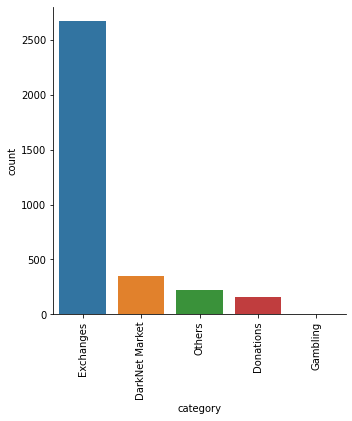

In [ ]:
# subgraph count by category, excluding unknown
graph_entities(all_sgnx, True, False,'')

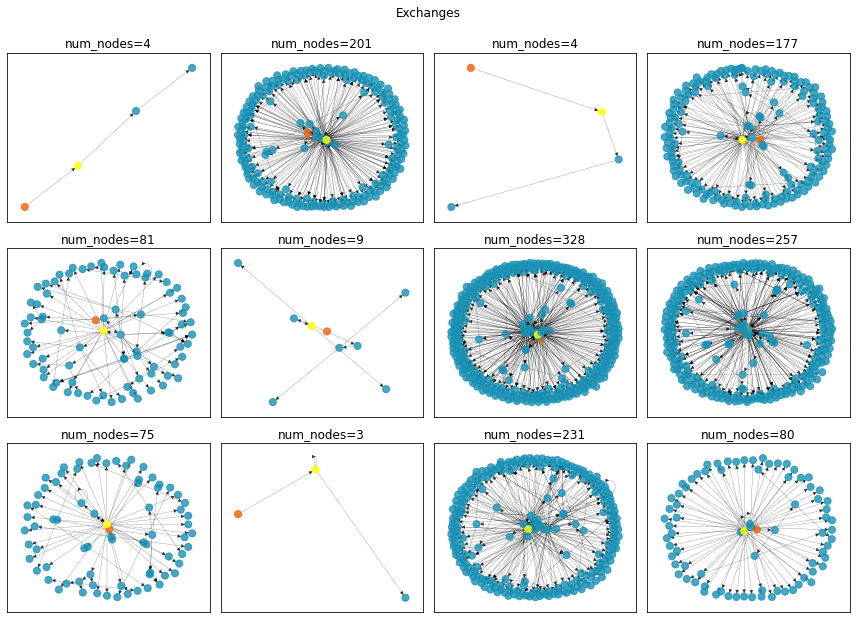

In [ ]:
# sample subgraphs for category Exchanges
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Exchanges']
plot_graph_mosaic(3, 4, graphs, 12,9,'Exchanges')

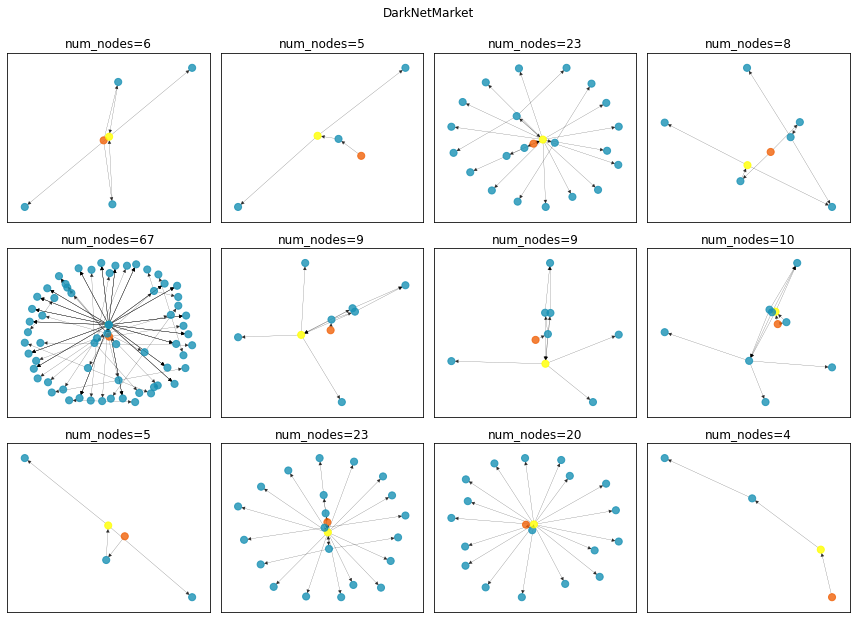

In [154]:
# sample subgraphs for category DarkNet Market
graphs = [graph for graph in all_sgnx if graph.graph['category']=='DarkNet Market']
plot_graph_mosaic(3, 4, graphs, 12,9,'DarkNetMarket')

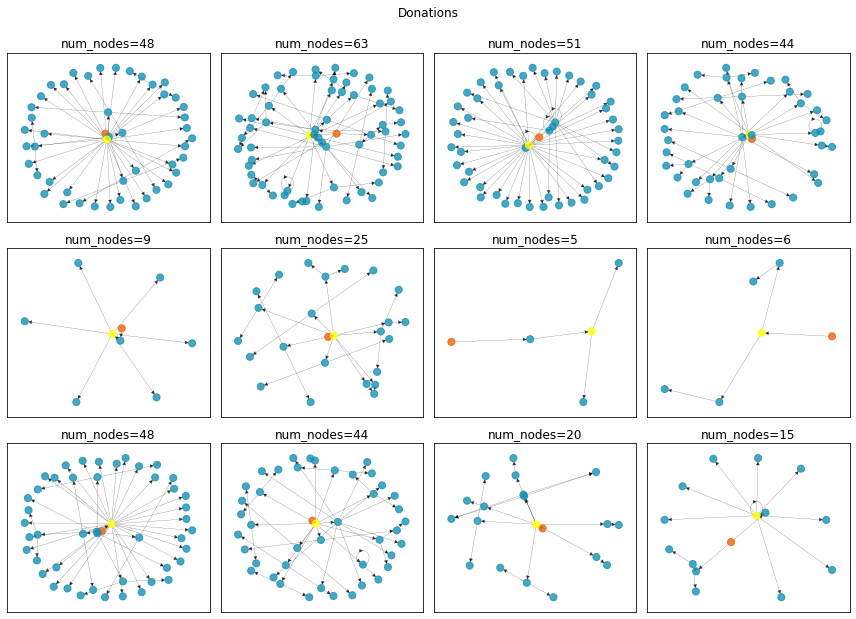

In [ ]:
# sample subgraphs for category Donations
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Donations']
plot_graph_mosaic(3, 4, graphs, 12,9,'Donations')

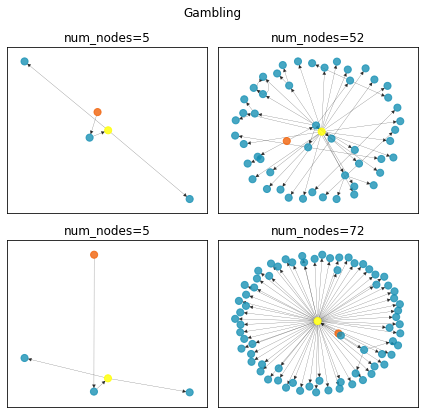

In [ ]:
# sample subgraphs for category Gambling
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Gambling']
plot_graph_mosaic(2, 2, graphs, 6,6,'Gambling')

###Exchanges

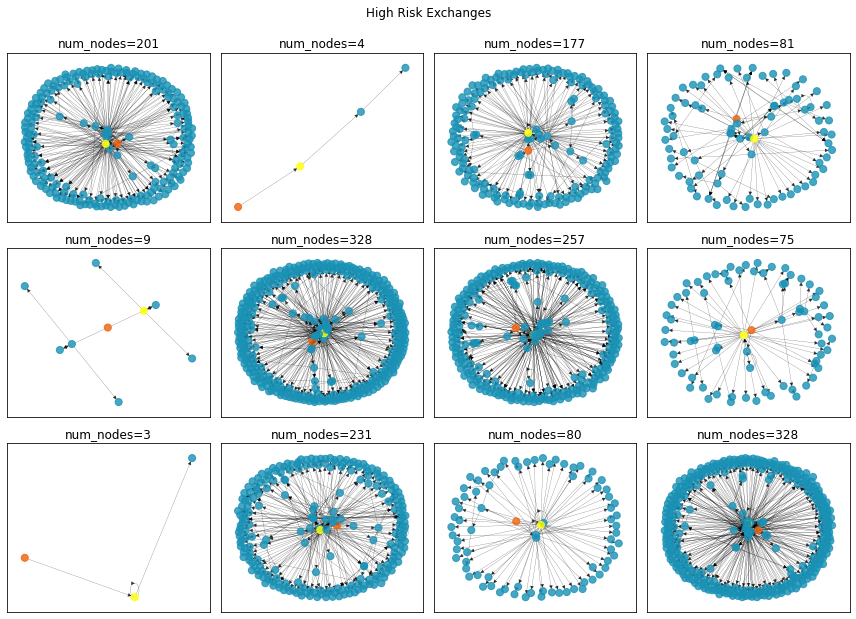

In [ ]:
# sample subgraphs for category Exchanges and labeled high risk
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==1]
plot_graph_mosaic(3, 4, graphs, 12,9,'High Risk Exchanges')

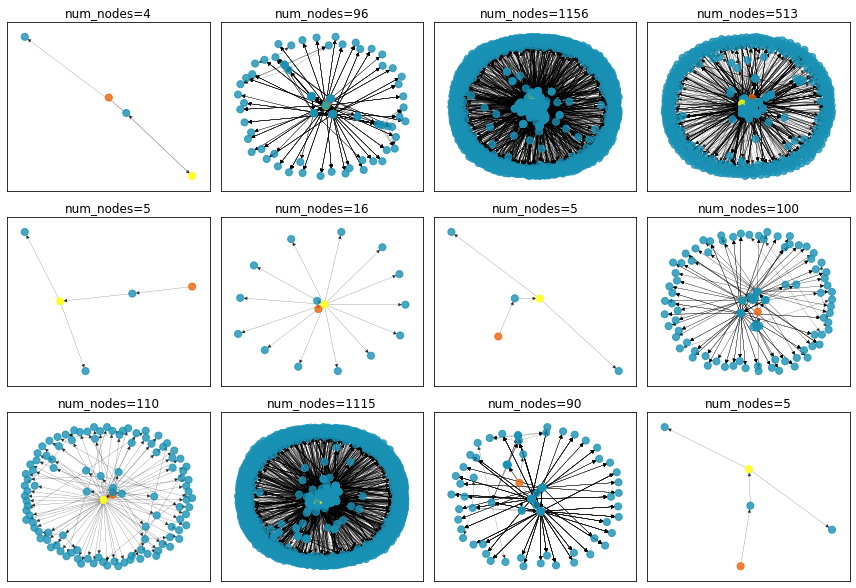

In [ ]:
# sample subgraphs for category Exchanges and labeled low risk
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==0]
plot_graph_mosaic(3, 4, graphs, 12,9,'')

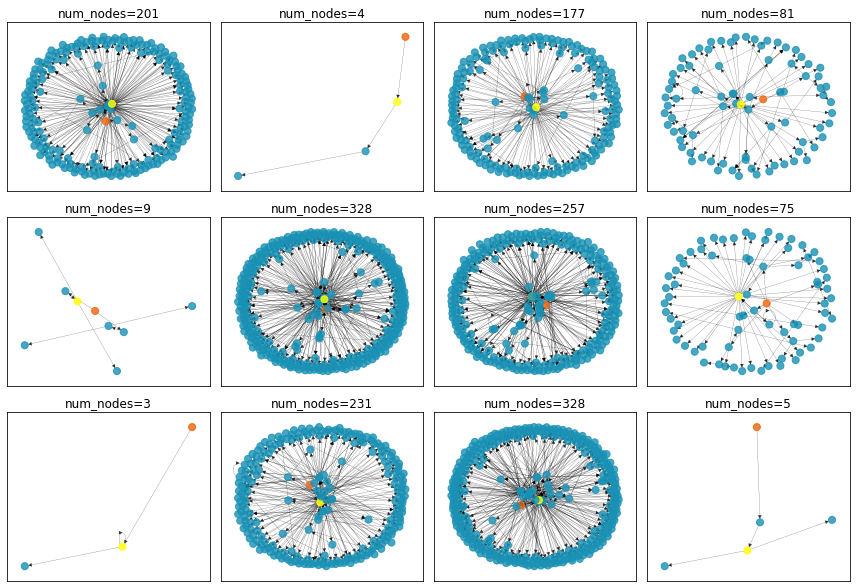

In [ ]:
# sample subgraphs for category Exchanges and labeled high risk and correctly predicted
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==1 and graph.graph['match_pred_flag']==1]
plot_graph_mosaic(3, 4, graphs, 12,9,'')

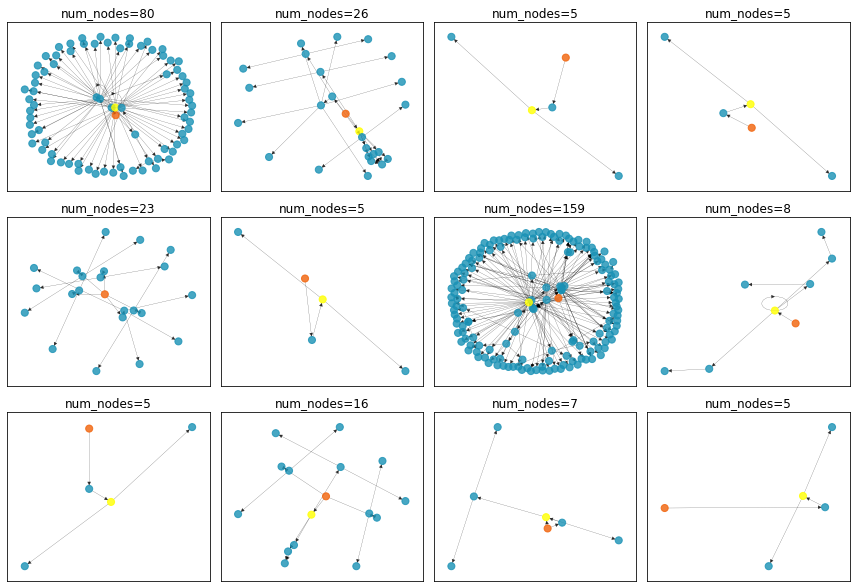

In [ ]:
# sample subgraphs for category Exchanges and labeled high risk and inccorrectly predicted
graphs = [graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==1 and graph.graph['match_pred_flag']==0]
plot_graph_mosaic(3, 4, graphs, 12,9,'')

###Exchanges proportions

In [ ]:
# calculate multiple counts of subgraphs
# total subgraphs
total_graphs = len([graph for graph in all_sgnx])
# total subgraphs that have category assigned (clovr)
total_labeled = len([graph for graph in all_sgnx if graph.graph['category']!='nan'])
# total subgraphs which category is Exchanges
total_exchanges = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges'])
# total subgraphs which category is Exchanges and are labeled high risk
exchanges_high_risk = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==1])
# total subgraphs which category is Exchanges and are labeled low risk
exchanges_low_risk = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==0])
# total subgraphs which category is Exchanges and are correctly predicted
exchanges_overall_pred = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['match_pred_flag']==1])
# total subgraphs which category is Exchanges and are incorrectly predicted
exchanges_overall_nopred = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['match_pred_flag']==0])
# total subgraphs which category is Exchanges and are high risk and are correctly predicted
exchanges_hr_pred = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==1 and graph.graph['match_pred_flag']==1])
# total subgraphs which category is Exchanges and are high risk and are incorrectly predicted
exchanges_hr_nopred = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==1 and graph.graph['match_pred_flag']==0])
# total subgraphs which category is Exchanges and are low risk and are correctly predicted
exchanges_lr_pred = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==0 and graph.graph['match_pred_flag']==1])
# total subgraphs which category is Exchanges and are low risk and are incorrectly predicted
exchanges_lr_nopred = len([graph for graph in all_sgnx if graph.graph['category']=='Exchanges' and graph.graph['label']==0 and graph.graph['match_pred_flag']==0])

print(f'Percentage of subgraphs with Category label: {total_labeled/total_graphs:.3f}')
print(f'Percentage of subgraphs Exchanges from all Category labels: {total_exchanges/total_labeled:.3f}')
print(f'Percentage of subgraphs Exchanges/High risk: {exchanges_high_risk/total_exchanges:.3f}')
print(f'Percentage of subgraphs Exchanges/High risk correctly predicted: {exchanges_hr_pred/exchanges_high_risk:.3f}')
print(f'Percentage of subgraphs Exchanges/Low risk: {exchanges_low_risk/total_exchanges:.3f}')
print(f'Percentage of subgraphs Exchanges/Low risk correctly predicted: {exchanges_lr_pred/exchanges_low_risk:.3f}')
print(f'Percentage of subgraphs Exchanges/All correctly predicted: {exchanges_overall_pred/total_exchanges:.3f}')

Percentage of subgraphs with Category label: 0.117
Percentage of subgraphs Exchanges from all Category labels: 0.784
Percentage of subgraphs Exchanges/High risk: 0.694
Percentage of subgraphs Exchanges/High risk correctly predicted: 0.836
Percentage of subgraphs Exchanges/Low risk: 0.306
Percentage of subgraphs Exchanges/Low risk correctly predicted: 0.933
Percentage of subgraphs Exchanges/All correctly predicted: 0.866


## Recall and value

###Random Forest

In [ ]:
# get random forest prediction from file
with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/RF_test_pred.csv', "rb") as input_file:
    test_pred_rf = pd.read_csv(input_file)
    test_pred_rf['set'] = 'test'
    test_pred_rf.columns = ['id','actual','pred','set']
    print(len(test_pred_rf))

20415


In [ ]:
# add value from node features and match flag to rf prediction data frame
test_pred_rf['txn_total_input'] = [node_features.loc[id]['txn_total_input_address'] for id in test_pred_rf['id'] if id in node_features.index]
test_pred_rf['match_flag'] = np.where(test_pred_rf['actual']==test_pred_rf['pred'], 1,0)

In [ ]:
# calculate value catched and value missed for RF
# there is some weird warning here, temporarly here to clean up
import warnings
warnings.filterwarnings('ignore')

value_catched = test_pred_rf[(test_pred_rf.match_flag==1) & (test_pred_rf.actual==1)]['txn_total_input'].sum()
value_missed = test_pred_rf[(test_pred_rf.match_flag==0) & (test_pred_rf.actual==1)]['txn_total_input'].sum()
value_passed = test_pred_rf[(test_pred_rf.match_flag==1) & (test_pred_rf.actual==0)]['txn_total_input'].sum()
value_stalled = test_pred_rf[(test_pred_rf.match_flag==0) & (test_pred_rf.actual==0)]['txn_total_input'].sum()

In [ ]:
# calculate value passed and value stalled for RF

print('Random Forest (Recall)')
print(f'Value catched {value_catched:>12,.2f}')
print(f'Value missed {value_missed:>12,.2f}')
print(f'Ratio {value_catched/(value_missed+value_catched)}')
print('-----------------------------')
print('Random Forest (Precision)')
print(f'Value passed {value_passed:>12,.2f}')
print(f'Value stalled {value_stalled:>12,.2f}')
print(f'Ratio {value_passed/(value_stalled+value_passed)}')

Random Forest (Recall)
Value catched 1,130,367,008,248.60
Value missed 833,190,424,845.68
Ratio 0.5756730051268772
-----------------------------
Random Forest (Precision)
Value passed 3,707,255,087,254.12
Value stalled 2,607,619,831,014.82
Ratio 0.5870670654978493


###GAT

In [ ]:
# add value from node features and match flag to rf prediction data frame (read earlier)
test_pred['txn_total_input'] = [node_features.loc[id]['txn_total_input_address'] for id in test_pred['id'] if id in node_features.index]
test_pred['match_flag'] = np.where(test_pred['actual']==test_pred['pred'], 1,0)

In [ ]:
# calculate value catched and value missed for GAT

value_catched = test_pred[(test_pred.match_flag==1) & (test_pred.actual==1)]['txn_total_input'].sum()
value_missed = test_pred[(test_pred.match_flag==0) & (test_pred.actual==1)]['txn_total_input'].sum()
value_passed = test_pred[(test_pred.match_flag==1) & (test_pred.actual==0)]['txn_total_input'].sum()
value_stalled = test_pred[(test_pred.match_flag==0) & (test_pred.actual==0)]['txn_total_input'].sum()


In [ ]:
# calculate value passed and value stalled for GAT
print('GAT (Recall)')
print(f'Value catched {value_catched:>12,.2f}')
print(f'Value missed {value_missed:>12,.2f}')
print(f'Ratio {value_catched/(value_missed+value_catched)}')
print('-----------------------------')
print('GAT (Precision)')
print(f'Value passed {value_passed:>12,.2f}')
print(f'Value stalled {value_stalled:>12,.2f}')
print(f'Ratio {value_passed/(value_stalled+value_passed)}')

GAT (Recall)
Value catched 1,095,946,795,362.38
Value missed 43,237,265,007.92
Ratio 0.9620454090677246
-----------------------------
GAT (Precision)
Value passed 1,593,786,817,805.78
Value stalled 535,935,739,259.90
Ratio 0.7483541987749271
